In [1]:
import os
import cv2
from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import tensorflow as tf
from keras import backend
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Concatenate, UpSampling2D, Reshape, Activation, ZeroPadding2D, Convolution2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras.backend import log, epsilon
from keras.losses import binary_crossentropy

import warnings
warnings.filterwarnings("ignore")

le = LabelEncoder()
scaler = StandardScaler()

plt.grid(None)
random_state=42
%matplotlib inline

# from google.colab import drive
# drive.mount('/content/drive')

2023-03-17 07:32:08.217678: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


################################

# PART-A

################################

## 1. Import and Understand the data

### A. Import and read ‘images.npy’.

In [2]:
# np_arr=np.load("/content/drive/My Drive/GL/CV-2 Dataset/images (3).npy",allow_pickle=True)
np_arr=np.load("images.npy",allow_pickle=True)
images_df=pd.DataFrame(np_arr)
images_df

0  \
0    [[[42, 37, 34], [56, 51, 48], [71, 66, 63], [7...   
1    [[[207, 216, 227, 255], [206, 216, 227, 255], ...   
2    [[[91, 61, 33], [95, 65, 37], [94, 64, 38], [9...   
3    [[[0, 0, 0, 255], [0, 0, 0, 255], [0, 0, 0, 25...   
4    [[[250, 250, 250], [250, 250, 250], [250, 250,...   
..                                                 ...   
404  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
405  [[[21, 36, 17], [21, 36, 17], [21, 36, 17], [2...   
406  [[[2, 2, 4], [1, 2, 4], [1, 2, 4], [2, 3, 5], ...   
407  [[[20, 4, 4], [20, 4, 4], [20, 4, 4], [20, 4, ...   
408  [[[106, 128, 149], [113, 135, 156], [112, 134,...   

                                                     1  
0    [{'label': ['Face'], 'notes': '', 'points': [{...  
1    [{'label': ['Face'], 'notes': '', 'points': [{...  
2    [{'label': ['Face'], 'notes': '', 'points': [{...  
3    [{'label': ['Face'], 'notes': '', 'points': [{...  
4    [{'label': ['Face'], 'notes': '', 'points': [{...  
..                                                 ...  
404  [{'label': ['Face'], 'notes': '', 'points': [{...  
405  [{'label': ['Face'], 'notes': '', 'points': [{...  
406  [{'label': ['Face'], 'notes': '', 'points': [{...  
407  [{'label': ['Face'], 'notes': '', 'points': [{...  
408  [{'label': ['Face'], 'notes': '', 'points': [{...  

[409 rows x 2 columns]

Total of 409 data is present.

### B. Split the data into Features(X) & labels(Y). Unify shape of all the images.

In [3]:
images_df.loc[1][1]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.7053087757313109, 'y': 0.23260437375745527},
   {'x': 0.7692307692307693, 'y': 0.36182902584493043}],
  'imageWidth': 1280,
  'imageHeight': 697}]

Dataset contains images array in column 0 and in column 1 contains different details like, label, notes, points, width and height.

In [4]:
# Checking is label same for all datas
l=[]
for i in images_df.loc[:][1]:
    for k in i:
        if k['label'] not in l:
            l.append(k['label'])
l

[['Face']]

As label is same in whole dataset, so there is no use of key "label", mainly our dataset will be using points and image size for its checks.
As MobileNet architecture will be used, so input image size will be 224*224.

In [5]:
# Unify shape of all the images
IMAGE_HEIGHT_MOBILE_NET=224
IMAGE_WIDTH_MOBILE_NET=224

In [6]:
features=np.zeros((int(images_df.shape[0]),IMAGE_HEIGHT_MOBILE_NET,IMAGE_WIDTH_MOBILE_NET,3), dtype=np.float32)
labels=np.zeros((int(images_df.shape[0]),IMAGE_HEIGHT_MOBILE_NET,IMAGE_WIDTH_MOBILE_NET,3), dtype=np.float32)

for index,row in images_df.iterrows():
  img = row[0]
  img = cv2.resize(img, dsize=(IMAGE_HEIGHT_MOBILE_NET, IMAGE_WIDTH_MOBILE_NET), interpolation=cv2.INTER_CUBIC)
  try:
    img = img[:, :, :3]
  except:
    continue
  features[index] = preprocess_input(np.array(img, dtype=np.float32))
  for i in row[1]:
      x1 = int(i["points"][0]['x'] * IMAGE_WIDTH_MOBILE_NET)
      x2 = int(i["points"][1]['x'] * IMAGE_WIDTH_MOBILE_NET)
      y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT_MOBILE_NET)
      y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT_MOBILE_NET)
      labels[index][y1:y2, x1:x2] = 1

In [7]:
features.shape,labels.shape

((409, 224, 224, 3), (409, 224, 224, 3))

Data is split into features and labels.

### C. Split the data into train and test[400:9].

In [8]:
X_image_train,X_image_test,y_image_train,y_image_test = train_test_split(features,labels,test_size=9,random_state=random_state)

In [9]:
print('X_train dataset: ',X_image_train.shape)
print('X_test dataset: ',X_image_test.shape)
print('y_train dataset: ',y_image_train.shape)
print('y_test dataset: ',y_image_test.shape)

X_train dataset:  (400, 224, 224, 3)
X_test dataset:  (9, 224, 224, 3)
y_train dataset:  (400, 224, 224, 3)
y_test dataset:  (9, 224, 224, 3)


### D. Select random image from the train data and display original image and masked image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


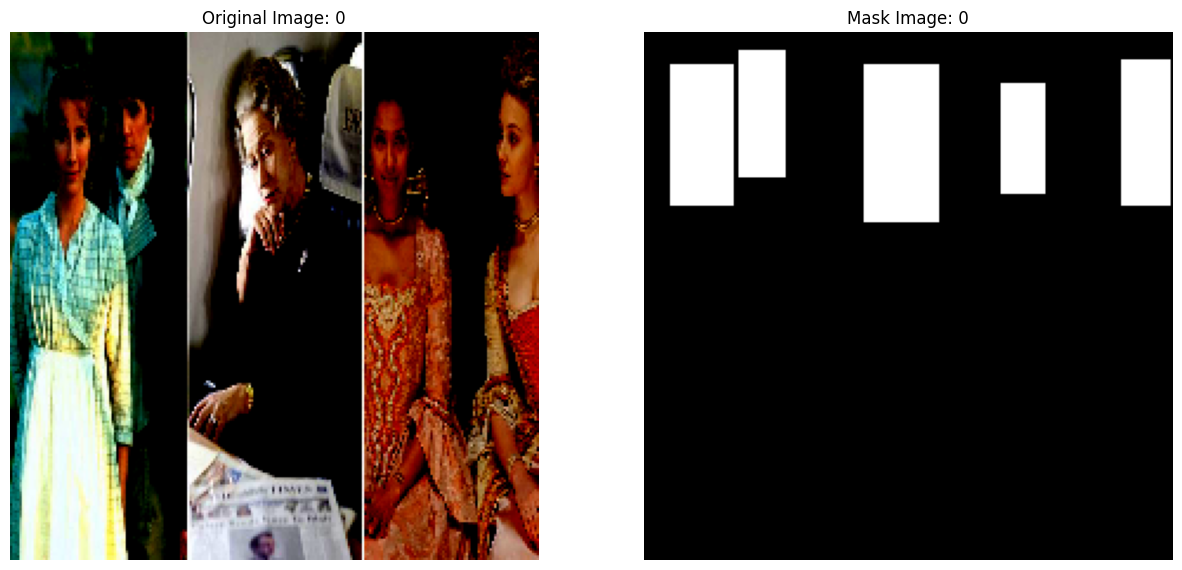

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


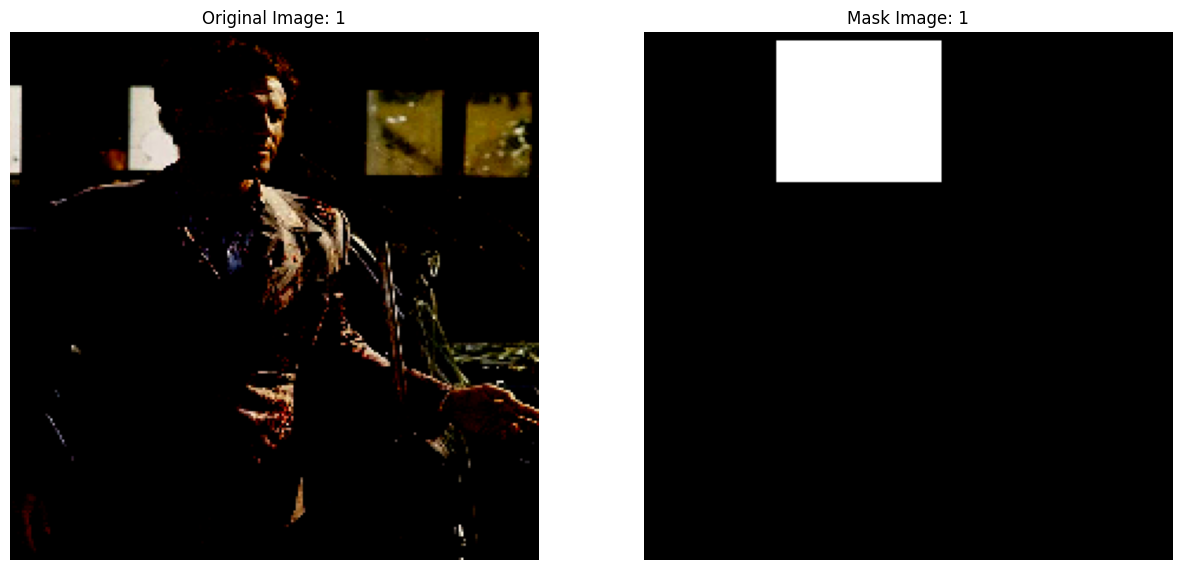

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


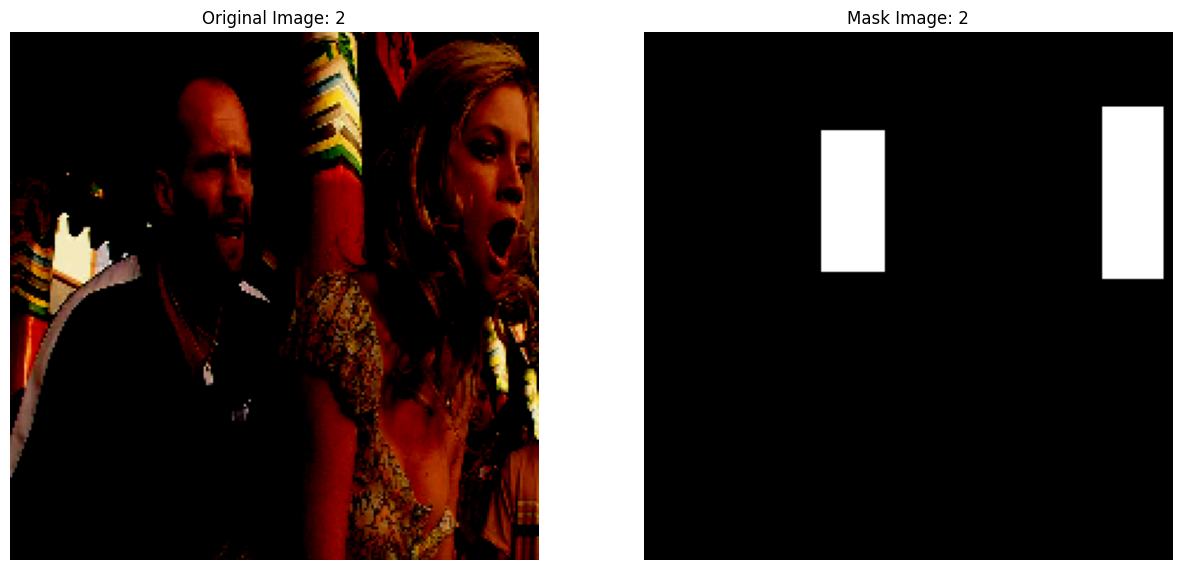

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


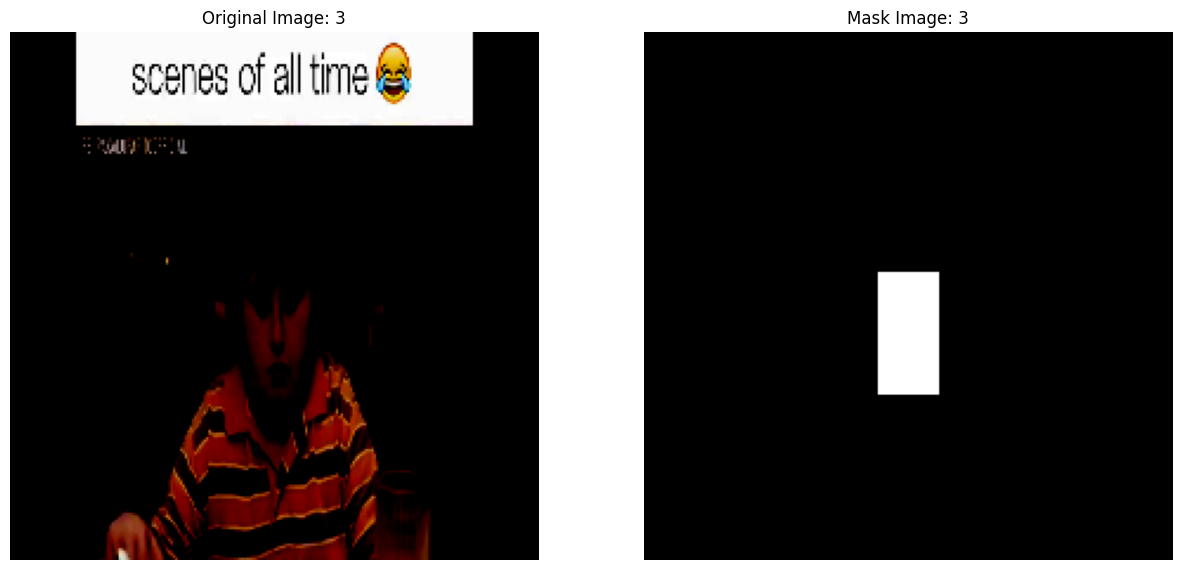

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


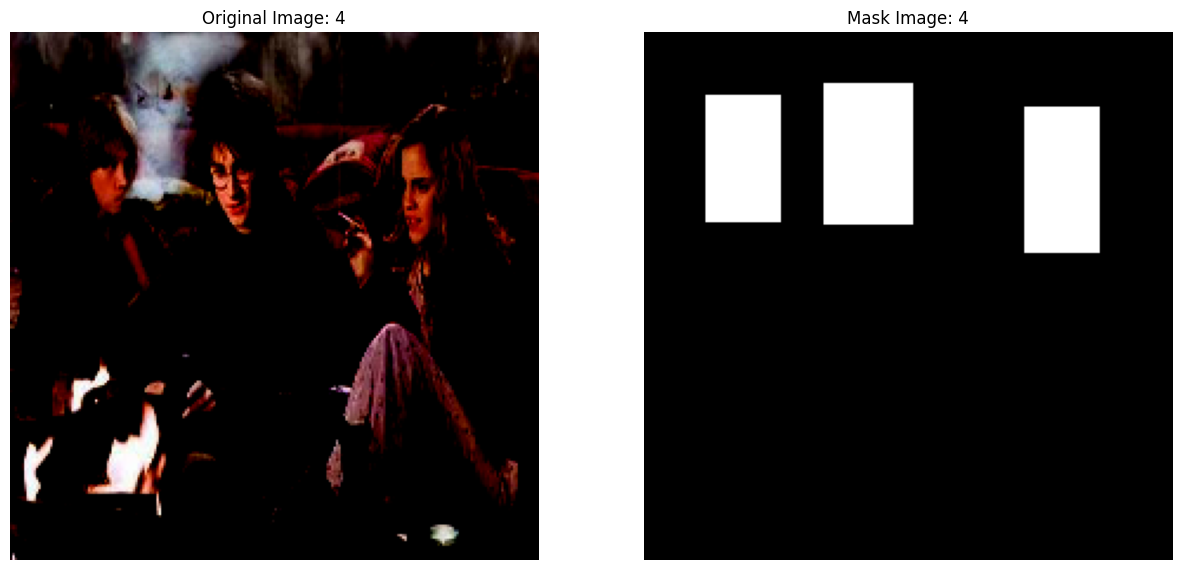

In [10]:
np.random.seed(random_state)
rand_idx = np.random.randint(low=0,high=X_image_train.shape[0],size=5)

for i,j in enumerate(rand_idx):
  
  plt.figure(figsize=(15,7))

  plt.subplot(1,2,1),plt.imshow(X_image_train[i]),plt.axis('off'),plt.title('Original Image: {}'.format(i))
  plt.subplot(1,2,2),plt.imshow(y_image_train[i]),plt.axis('off'),plt.title('Mask Image: {}'.format(i))

  plt.show()

## 2. Model building.

### A. Design a face mask detection model.

In [11]:
backend.clear_session()
tf.random.set_seed(random_state)

# Checking summary to build up-sampling using existing architecture
model = MobileNet(input_shape=(IMAGE_HEIGHT_MOBILE_NET, IMAGE_WIDTH_MOBILE_NET, 3), include_top=False, weights="imagenet")

model.summary()

2023-03-17 07:32:53.428265: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

From summary will be extracting those CONV2D which will be used for up-sampling:
- conv_pw_1_relu (ReLU) -> (None, 112, 112, 64)
- conv_pw_2_relu (ReLU) -> (None, 56, 56, 128)
- conv_pw_5_relu (ReLU) -> (None, 28, 28, 256)
- conv_pw_11_relu (ReLU) -> (None, 14, 14, 512)
- conv_pw_13_relu (ReLU) -> (None, 7, 7, 1024)

In [12]:
# Create model
def model_creation(trainable):

    for layer in model.layers:
        layer.trainable = trainable

    x0=model.layers[0].input

    x1=model.get_layer("conv_pw_1_relu").output
    x2=model.get_layer("conv_pw_2_relu").output
    x3=model.get_layer("conv_pw_5_relu").output
    x4=model.get_layer("conv_pw_11_relu").output
    x5=model.get_layer("conv_pw_13_relu").output

    # Expanding Path
    x6=Concatenate()([UpSampling2D()(x5),x4])
    # x6=Conv2D(1024, (3, 3), padding="same")(x6)
    # x6=BatchNormalization()(x6)
    # x6=Activation("relu")(x6)
    # x6=Conv2D(1024, (5, 5), padding="same")(x6)
    # x6=BatchNormalization()(x6)
    # x6=Activation("relu")(x6)
    # x6=Dropout(0.2)(x6)

    x7=Concatenate()([UpSampling2D()(x6),x3])
    # x7=Conv2D(512, (3, 3), padding="same")(x7)
    # x7=BatchNormalization()(x7)
    # x7=Activation("relu")(x7)
    # x7=Conv2D(512, (5, 5), padding="same")(x7)
    # x7=BatchNormalization()(x7)
    # x7=Activation("relu")(x7)
    # x7=Dropout(0.2)(x7)

    x8=Concatenate()([UpSampling2D()(x7),x2])
    # x8=Conv2D(256, (3, 3), padding="same")(x8)
    # x8=BatchNormalization()(x8)
    # x8=Activation("relu")(x8)
    # x8=Conv2D(256, (5, 5), padding="same")(x8)
    # x8=BatchNormalization()(x8)
    # x8=Activation("relu")(x8)
    # x8=Dropout(0.2)(x8)

    x9=Concatenate()([UpSampling2D()(x8),x1])
    # x9=Conv2D(128, (3, 3), padding="same")(x9)
    # x9=BatchNormalization()(x9)
    # x9=Activation("relu")(x9)
    # x9=Conv2D(128, (5, 5), padding="same")(x9)
    # x9=BatchNormalization()(x9)
    # x9=Activation("relu")(x9)
    # x9=Dropout(0.2)(x9)

    x10=Concatenate()([UpSampling2D()(x9),x0])
    # x10=Conv2D(64, (3, 3), padding="same")(x10)
    # x10=BatchNormalization()(x10)
    # x10=Activation("relu")(x10)
    # x10=Conv2D(64, (5, 5), padding="same")(x10)
    # x10=BatchNormalization()(x10)
    # x10=Activation("relu")(x10)
    # x10=Dropout(0.2)(x10)

    x = Conv2D(3, kernel_size=1, activation="sigmoid")(x10)

    #Output layer
    x_out = Reshape((IMAGE_HEIGHT_MOBILE_NET, IMAGE_WIDTH_MOBILE_NET, 3))(x)

    return Model(inputs=model.input, outputs=x_out, name=model.name)

In [13]:
image_model=model_creation(False)

# Summary
image_model.summary()

Model: "mobilenet_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                

### B. Design your own Dice Coefficient and Loss function.

$$ Dice Coefficient= \frac{2*|X∩Y|}{|X|+|Y|} $$

In [14]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### C. Train and tune the model as required.
### D. Evaluate and share insights on performance of the model.

In [15]:
adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)

image_model.compile(loss=loss, optimizer=adam, metrics=[dice_coefficient])

In [16]:
# Define callbacks

checkpoint = ModelCheckpoint("image_model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=6, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.3, patience=6, min_lr=1e-6, verbose=1, mode="min")

In [17]:
# Model fitting
image_history=image_model.fit(X_image_train, y_image_train, validation_split=0.2, epochs=20, batch_size=5, callbacks=[checkpoint, reduce_lr, stop])

Epoch 1/20
64/64 [==============================] - ETA: 0s - loss: 2.0201 - dice_coefficient: 0.2391
Epoch 1: loss improved from inf to 2.02007, saving model to image_model-2.02.h5
64/64 [==============================] - 209s 3s/step - loss: 2.0201 - dice_coefficient: 0.2391 - val_loss: 1.7279 - val_dice_coefficient: 0.2821 - lr: 1.0000e-04
Epoch 2/20
64/64 [==============================] - ETA: 0s - loss: 1.5454 - dice_coefficient: 0.3204
Epoch 2: loss improved from 2.02007 to 1.54537, saving model to image_model-1.55.h5
64/64 [==============================] - 210s 3s/step - loss: 1.5454 - dice_coefficient: 0.3204 - val_loss: 1.4100 - val_dice_coefficient: 0.3552 - lr: 1.0000e-04
Epoch 3/20
64/64 [==============================] - ETA: 0s - loss: 1.3031 - dice_coefficient: 0.3828
Epoch 3: loss improved from 1.54537 to 1.30306, saving model to image_model-1.30.h5
64/64 [==============================] - 159s 2s/step - loss: 1.3031 - dice_coefficient: 0.3828 - val_loss: 1.2383 - val

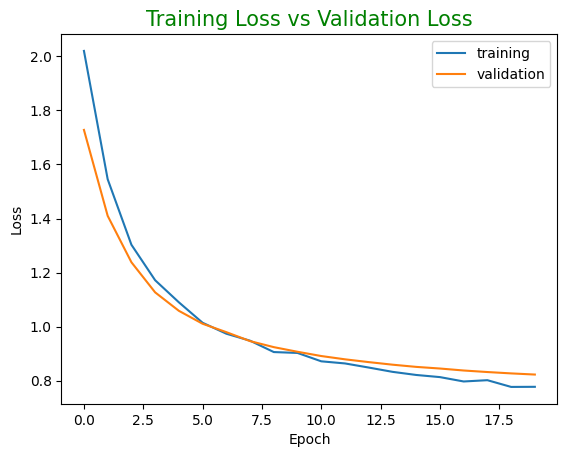

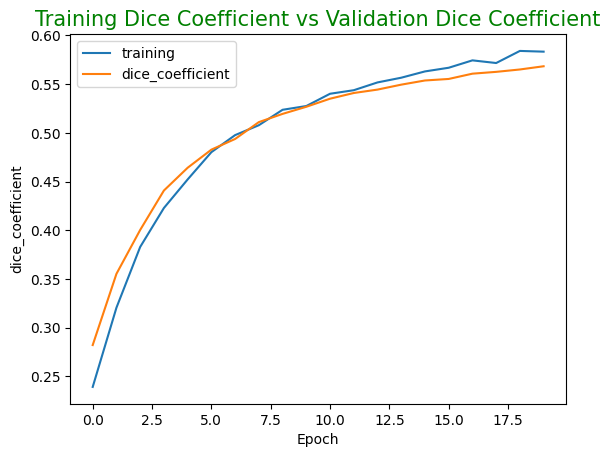

In [18]:
# Capturing learning history per epoch
image_hist  = pd.DataFrame(image_history.history)
image_hist['epoch'] = image_history.epoch

# Plotting Loss at different epochs
plt.title('Training Loss vs Validation Loss',fontsize=15,color="green")
plt.plot(image_hist['loss'])
plt.plot(image_hist['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(("training" , "validation") , loc ='best')
plt.show()

# Plotting Accuracy at different epochs
plt.title('Training Dice Coefficient vs Validation Dice Coefficient',fontsize=15,color="green")
plt.plot(image_hist['dice_coefficient'])
plt.plot(image_hist['val_dice_coefficient'])
plt.ylabel('dice_coefficient')
plt.xlabel('Epoch')
plt.legend(("training" , "dice_coefficient") , loc ='best')
plt.show()

In [19]:
# calculate score of training data
image_model.evaluate(X_image_train, y_image_train, batch_size=5, verbose=1)

80/80 [==============================] - 117s 1s/step - loss: 0.7811 - dice_coefficient: 0.5834


[0.7811383008956909, 0.5833777189254761]

In [20]:
# calculate score of training data
image_model.evaluate(X_image_test, y_image_test, batch_size=5, verbose=1)

2/2 [==============================] - 5s 1s/step - loss: 0.7139 - dice_coefficient: 0.6041


[0.7138651609420776, 0.6040586829185486]

Performance seems to be same for less data.

## 3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


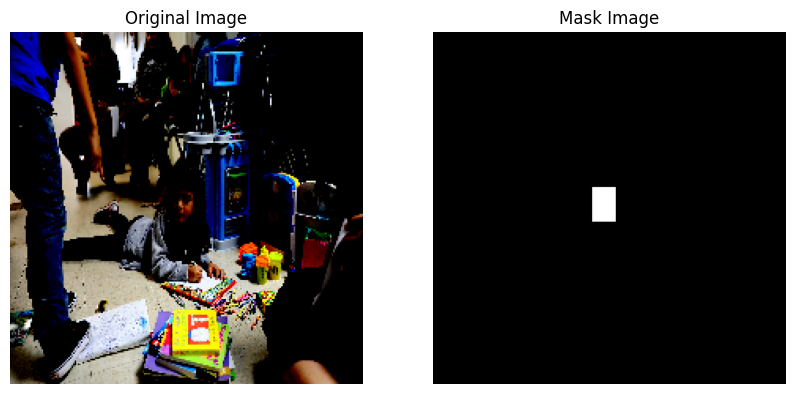

In [21]:
test_image=X_image_test[3]
test_mask_image=y_image_test[3]
plt.figure(figsize=(10,7))

plt.subplot(1,2,1),plt.imshow(test_image),plt.axis('off'),plt.title('Original Image')
plt.subplot(1,2,2),plt.imshow(test_mask_image),plt.axis('off'),plt.title('Mask Image')

plt.show()

In [22]:
test_pred_image=image_model.predict(x=np.array([test_image]))[0]
test_pred_image

1/1 [==============================] - 1s 722ms/step


array([[[1.79198600e-04, 1.86963764e-04, 1.60396553e-03],
        [1.78231203e-04, 1.86342833e-04, 1.59752613e-03],
        [1.51960427e-04, 1.15855139e-04, 1.39357068e-03],
        ...,
        [4.38768657e-05, 1.87923346e-04, 1.22155485e-04],
        [7.03347760e-05, 1.41578916e-04, 1.15352137e-04],
        [7.03347760e-05, 1.41578916e-04, 1.15352137e-04]],

       [[1.79448383e-04, 1.87448750e-04, 1.60669920e-03],
        [1.78211136e-04, 1.86284917e-04, 1.59726676e-03],
        [1.51930130e-04, 1.15474300e-04, 1.39155763e-03],
        ...,
        [4.38803800e-05, 1.87993239e-04, 1.22178317e-04],
        [7.03347760e-05, 1.41578916e-04, 1.15352137e-04],
        [7.03347760e-05, 1.41578916e-04, 1.15352137e-04]],

       [[1.60454161e-04, 1.50734617e-04, 1.42820424e-03],
        [1.59874442e-04, 1.50351072e-04, 1.42415357e-03],
        [2.41434362e-04, 1.78508912e-04, 1.66682666e-03],
        ...,
        [5.80409396e-05, 2.31180224e-04, 1.30332730e-04],
        [4.53006942e-05, 1.26

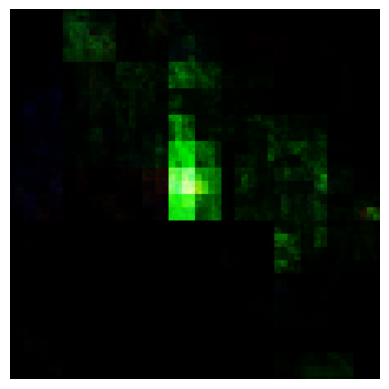

In [23]:
# plotting original predicted image
plt.imshow(test_pred_image, alpha=1)
plt.axis('off')
plt.grid(None)

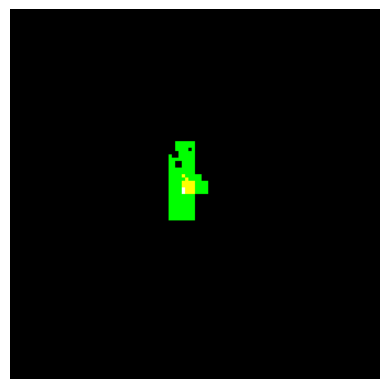

In [24]:
# custom plotting original predicted image
plt.imshow(1.0*(test_pred_image>0.7), alpha=1)
plt.axis('off')
plt.grid(None)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


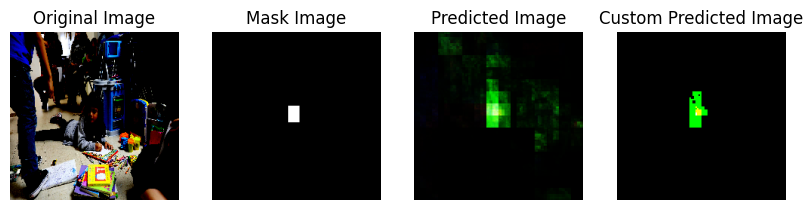

In [25]:
plt.figure(figsize=(10,7))

plt.subplot(1,4,1),plt.imshow(test_image),plt.axis('off'),plt.title('Original Image')
plt.subplot(1,4,2),plt.imshow(test_mask_image),plt.axis('off'),plt.title('Mask Image')
plt.subplot(1,4,3),plt.imshow(test_pred_image),plt.axis('off'),plt.title('Predicted Image')
plt.subplot(1,4,4),plt.imshow(1.0*(test_pred_image>0.7),alpha=1),plt.axis('off'),plt.title('Custom Predicted Image')

plt.show()

################################

# PART-B

################################

## 1. Read/import images from folder ‘training_images’.

In [26]:
# Extracting all the folders of the zip
# ZipFile('/content/drive/My Drive/GL/CV-2 Dataset/training_images-20211126T092819Z-001 (1).zip').extractall()
ZipFile('training_images-20211126T092819Z-001 (1).zip').extractall()

In [27]:
# Train folder
train_dir='training_images'
training_images_list=[]
for img_file in os.listdir(train_dir):
    img_path=os.path.join(train_dir,img_file)
    training_images_list.append([img_file, img_path])

# Creating dataframe
training_images_df=pd.DataFrame(training_images_list,columns=['Image_Name','image'])
training_images_df.head()

Image_Name                           image
0  real_00251.jpg  training_images/real_00251.jpg
1  real_00537.jpg  training_images/real_00537.jpg
2  real_00523.jpg  training_images/real_00523.jpg
3  real_00245.jpg  training_images/real_00245.jpg
4  real_00279.jpg  training_images/real_00279.jpg

In [28]:
training_images_df.shape

(1091, 2)

training_images folder contains 1091 images.

## 2. Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images.
## 3. From the same loop above, extract metadata of the faces and write into a DataFrame.

In [29]:
# face_classifier = cv2.CascadeClassifier('/content/drive/My Drive/GL/haarcascade_frontalface_default.xml')
face_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

training_images_final_df=pd.DataFrame(columns=['x','y','w','h','Total_Faces','Image_Name'])

In [30]:
for index, row in training_images_df.iterrows():

    img = plt.imread(row.__getitem__('image'))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.0485258, 6)

    list_x, list_y, list_w, list_h=[],[],[],[]

    for (x,y,w,h) in faces:
        list_x+=[str(x)]
        list_y+=[str(y)]
        list_w+=[str(w)]
        list_h+=[str(h)]

    training_images_final_df.loc[index]=[';'.join(list_x),';'.join(list_y),';'.join(list_w),';'.join(list_h),len(faces),row.get('Image_Name')]

In [31]:
training_images_final_df.head()

x    y    w    h  Total_Faces      Image_Name
0   93  142  392  392            1  real_00251.jpg
1   66   85  460  460            1  real_00537.jpg
2  115  150  385  385            1  real_00523.jpg
3   84  135  392  392            1  real_00245.jpg
4  140  202  381  381            1  real_00279.jpg

In [32]:
training_images_final_df.shape

(1091, 6)

## 4. Save the output Dataframe in .csv format.

In [33]:
training_images_final_df.to_csv("training_images_final_df.csv", index=False)

################################

# PART-C

################################

## 1. Unzip, read and Load data(‘PINS.zip’) into session.

In [34]:
# Extracting all the folders of the zip
# ZipFile('/content/drive/My Drive/GL/CV-2 Dataset/PINS.zip').extractall()
ZipFile('PINS.zip').extractall()

## 2. Write function to create metadata of the image.

In [35]:
def image_dim(path):
    with Image.open(path) as open_image:
        return open_image.size


class IdentityMetadata:
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

        self.original_name = name[5:]

        self.width, self.height = image_dim(self.image_path())

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

## 3. Write a loop to iterate through each and every image and create metadata for all the images.

In [36]:
def load_metadata(path):
    metadata = []
    for dirt in os.listdir(path):
        if dirt == '.DS_Store':
            continue
        for file in os.listdir(os.path.join(path, dirt)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(file)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, dirt, file))
    return np.array(metadata)

In [37]:
def load_image(path):
    path_arr=plt.imread(path)

    # Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
    path_arr=(path_arr/255.).astype(np.float32)

    return cv2.resize(path_arr, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

In [38]:
metadat_path_list=load_metadata('PINS')
metadat_list=[]

for meta_path in metadat_path_list:
    metadat_list.append(load_image(meta_path.image_path()))

metadata_arr_list=np.array(metadat_list)
metadata_arr_list.shape

(10770, 224, 224, 3)

## 4. Generate Embeddings vectors on the each face in the dataset.

In [39]:
def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [40]:
backend.clear_session()
tf.random.set_seed(random_state)

vgg_model=vgg_face()
# vgg_model.load_weights('/content/drive/My Drive/GL/CV-2 Dataset/vgg_face_weights.h5')
vgg_model.load_weights('vgg_face_weights.h5')

In [41]:
vgg_face_descriptor = Model(inputs=vgg_model.layers[0].input, outputs=vgg_model.layers[-2].output)

In [42]:
# Get embedding vector for first image in the metadata using the pre-trained model

img=metadata_arr_list[0]
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 1s 1s/step
(2622,)


In [43]:
embeddings = np.zeros((metadata_arr_list.shape[0], 2622))

for i, m in enumerate(metadata_arr_list):
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(m, axis=0),use_multiprocessing=True)[0]
    embeddings[i]=embedding_vector
embeddings.shape

1/1 [==============================] - 0s 179ms/step


(10770, 2622)

## 5. Build distance metrics for identifying the distance between two similar and dissimilar images.

In [44]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [45]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(metadata_arr_list[idx1]),plt.grid(None),plt.axis('off')
    plt.subplot(122)
    plt.imshow(metadata_arr_list[idx2]),plt.grid(None),plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


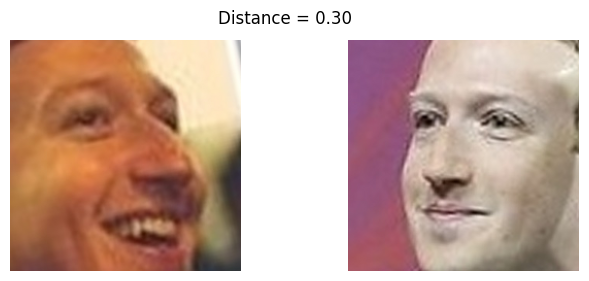

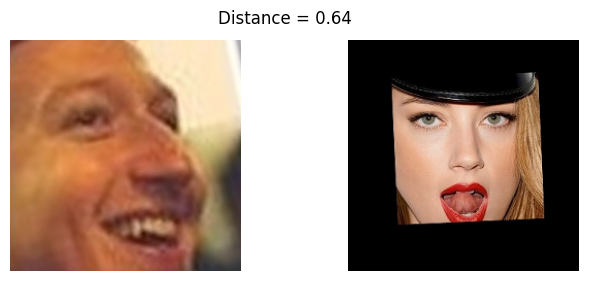

In [46]:
show_pair(2, 3)
show_pair(2, 180)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


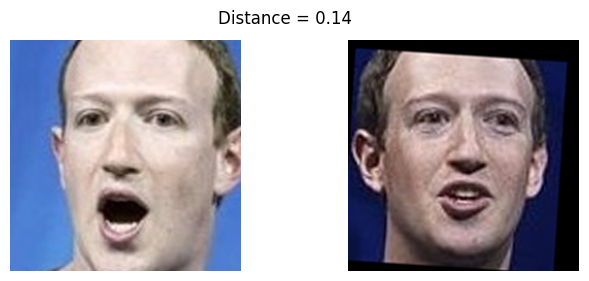

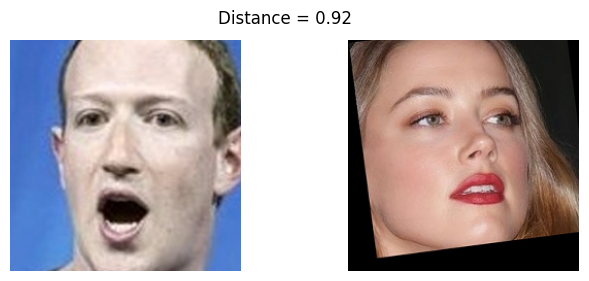

In [47]:
show_pair(30, 31)
show_pair(30, 100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


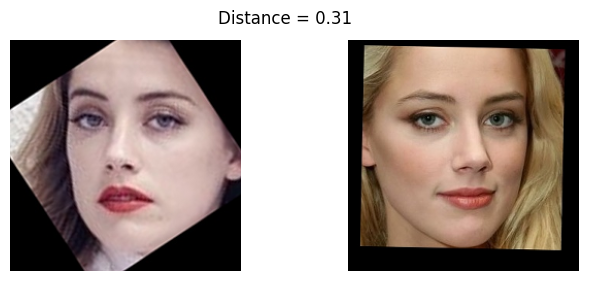

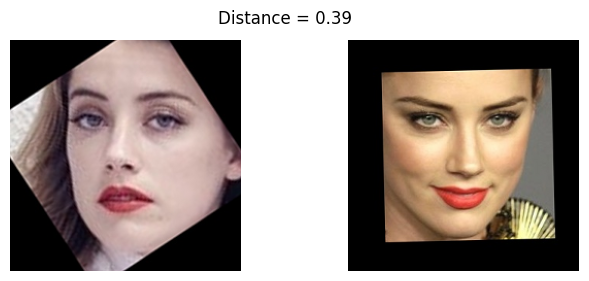

In [48]:
show_pair(70, 72)
show_pair(70, 115)

## 6. Use PCA for dimensionality reduction.

In [49]:
train_idx = np.arange(metadata_arr_list.shape[0]) % 9 != 0
test_idx = np.arange(metadata_arr_list.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_pins_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_pins_test = embeddings[test_idx]

targets = np.array([m.name for m in metadat_path_list])
y_pins_train = targets[train_idx]
y_pins_test = targets[test_idx]

In [50]:
print('X_train dataset: ',X_pins_train.shape)
print('X_test dataset: ',X_pins_test.shape)
print('y_train dataset: ',y_pins_train.shape)
print('y_test dataset: ',y_pins_test.shape)

X_train dataset:  (9573, 2622)
X_test dataset:  (1197, 2622)
y_train dataset:  (9573,)
y_test dataset:  (1197,)


In [51]:
# Using labelEncoder encoding targets

y_pins_train_encoded = le.fit_transform(y_pins_train)
y_pins_test_encoded = le.transform(y_pins_test)
y_pins_train_encoded.shape,y_pins_test_encoded.shape

((9573,), (1197,))

In [52]:
# Using standardScaler standardizing features

X_pins_train_std = scaler.fit_transform(X_pins_train)
X_pins_test_std = scaler.transform(X_pins_test)

X_pins_train_std.shape,X_pins_test_std.shape

((9573, 2622), (1197, 2622))

In [53]:
# Reduce feature dimensions using Principal Component Analysis

pca_pins_test = PCA()
pca_pins_test.fit_transform(X_pins_train_std)

array([[-1.57957811e+01,  4.68846344e+00,  1.64629516e+01, ...,
        -3.78887722e-03,  2.40825720e-03,  5.64052140e-04],
       [-5.65872652e+00, -2.14819335e+00,  2.74791579e+01, ...,
         1.42811219e-03,  2.05149669e-03,  4.39222974e-04],
       [-7.01777010e+00,  1.32009142e+00,  2.30901312e+01, ...,
        -3.04379489e-03,  2.43548083e-03,  2.52795289e-04],
       ...,
       [ 5.18987074e+00, -2.90326874e+01, -5.38214033e+00, ...,
         3.42532224e-04,  2.20419745e-03, -7.35897756e-04],
       [-1.87912046e+00, -2.88070608e+01, -1.11739671e+01, ...,
        -2.27147461e-03,  4.53801387e-03,  3.00904483e-04],
       [ 3.21933361e+00, -2.86680022e+01, -4.42296038e+00, ...,
         3.09817549e-04, -8.39364713e-04, -1.00605080e-04]])

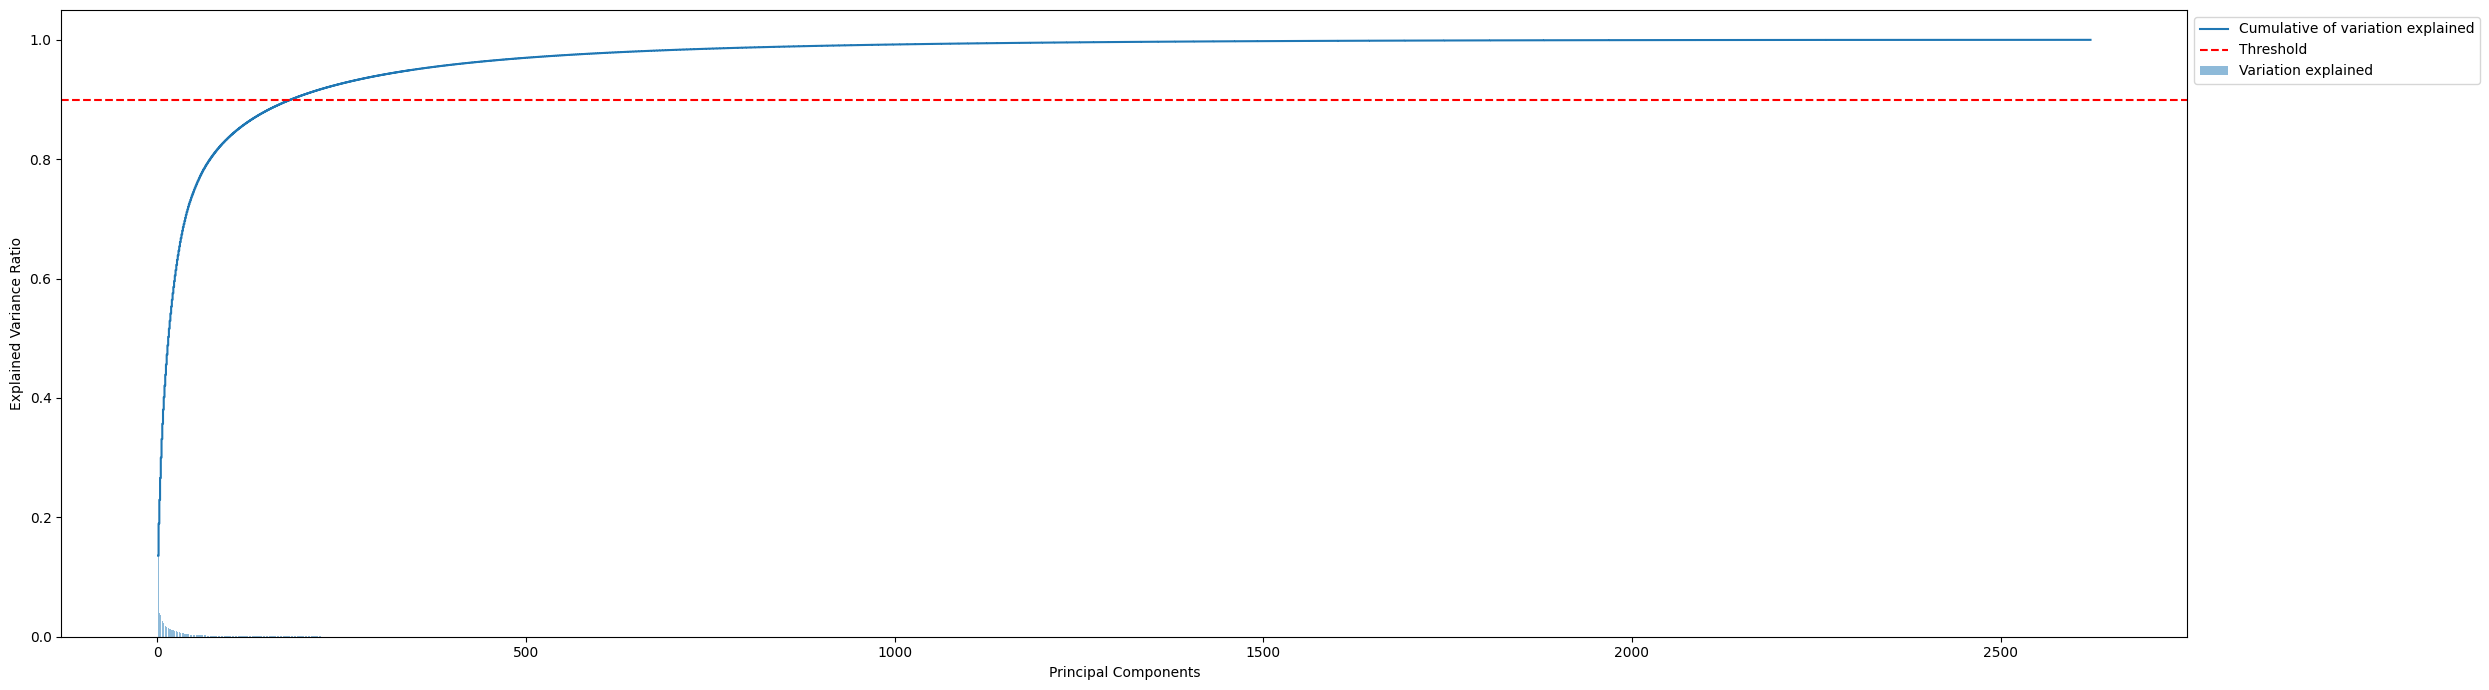

In [54]:
plt.figure(figsize=(25 , 7))
plt.bar(list(range(1,X_pins_train_std.shape[1]+1)),pca_pins_test.explained_variance_ratio_,alpha=0.5, align='center', label='Variation explained')
plt.step(list(range(1,X_pins_train_std.shape[1]+1)),np.cumsum(pca_pins_test.explained_variance_ratio_), where='mid', label='Cumulative of variation explained')
plt.axhline(0.9, c='r', linestyle = 'dashed', label = "Threshold")
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(bbox_to_anchor = (1.0, 1))
plt.tight_layout()
plt.show()

After visualizing above plot, threshold breakpoint at 90% of variance gives n_components as 128

In [55]:
pca_pins = PCA(n_components=128)
X_pins_train_pca = pca_pins.fit_transform(X_pins_train_std)
X_pins_test_pca = pca_pins.transform(X_pins_test_std)

In [56]:
X_pins_train_pca.shape, X_pins_test_pca.shape

((9573, 128), (1197, 128))

Above PCA derived features will be used as i/ps for SVM training.

## 7. Build an SVM classifier in order to map each image to its right person.

In [57]:
# defining parameter range
svm_param = {
    "C": [0.1, 1, 5, 10, 100],
    "gamma": [1, 0.1, 0.01, 0.001, 0.0001]
}

grid_svc = GridSearchCV(estimator=SVC(random_state=random_state), param_grid=svm_param, n_jobs=-1, cv=5, refit=True, verbose=1)

# fitting the model for grid search
grid_svc.fit(X_pins_train_pca, y_pins_train_encoded)

# print best parameter after tuning
print(grid_svc.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid_svc.best_estimator_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'C': 10, 'gamma': 0.0001}
SVC(C=10, gamma=0.0001, random_state=42)


In [58]:
grid_svc.best_estimator_.fit(X_pins_train_pca, y_pins_train_encoded)

SVC(C=10, gamma=0.0001, random_state=42)

In [59]:
y_pins_predict_svc = grid_svc.best_estimator_.predict(X_pins_test_pca)
y_pins_predict_svc.shape

(1197,)

In [60]:
print("Accuracy score Training dataset:{:.4f}".format(grid_svc.best_estimator_.score(X_pins_train_pca, y_pins_train_encoded)))
print("Accuracy score Testing dataset:{:.4f}".format(grid_svc.best_estimator_.score(X_pins_test_pca, y_pins_test_encoded)))

print(classification_report(y_pins_test_encoded,y_pins_predict_svc))

Accuracy score Training dataset:0.9987
Accuracy score Testing dataset:0.9674
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      0.93      0.96        14
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00         8
           5       1.00      0.89      0.94         9
           6       1.00      1.00      1.00         7
           7       0.93      1.00      0.97        14
           8       1.00      0.92      0.96        13
           9       1.00      1.00      1.00         9
          10       0.87      1.00      0.93        13
          11       0.92      1.00      0.96        12
          12       1.00      1.00      1.00        10
          13       0.91      1.00      0.95        10
          14       1.00      0.94      0.97        16
          15       1.00      0.93      0.97        15
    

## 8. Import and display the test images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


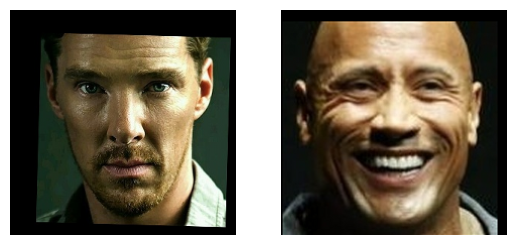

In [61]:
# plt.subplot(121),plt.imshow(load_image('/content/drive/My Drive/GL/CV-2 Dataset/Benedict Cumberbatch9.jpg')),plt.grid(None),plt.axis('off')
# plt.subplot(122),plt.imshow(load_image('/content/drive/My Drive/GL/CV-2 Dataset/Dwayne Johnson4.jpg')),plt.grid(None),plt.axis('off')

plt.subplot(121),plt.imshow(load_image('Benedict Cumberbatch9.jpg')),plt.grid(None),plt.axis('off')
plt.subplot(122),plt.imshow(load_image('Dwayne Johnson4.jpg')),plt.grid(None),plt.axis('off')

plt.show()

## 9. Use the trained SVM model to predict the face on both test images.

In [62]:
def predict_test(test_img_path):

    # Converting image to normalized array
    test_img=load_image(test_img_path)

    # Generate embedding vector of desired image
    test_embedding_vector=vgg_face_descriptor.predict(np.expand_dims(test_img, axis=0))

    # Transforming desired image so that PCA can train
    test_embedding_vector_scaled=scaler.transform(test_embedding_vector)

    # Dimension reduction using PCA
    test_img_pca=pca_pins.transform(test_embedding_vector_scaled)

    # Classifying image label using SVC
    test_img_svc=grid_svc.best_estimator_.predict(test_img_pca)[0]

    plt.imshow(test_img)
    plt.title("Identified as "+le.classes_[test_img_svc])
    plt.grid(None)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 1s 771ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


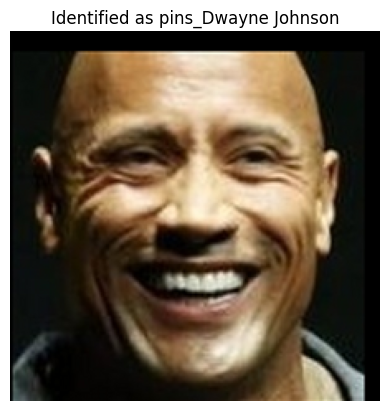

In [63]:
# predict_test('/content/drive/My Drive/GL/CV-2 Dataset/Dwayne Johnson4.jpg')
predict_test('Dwayne Johnson4.jpg')

1/1 [==============================] - 0s 244ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


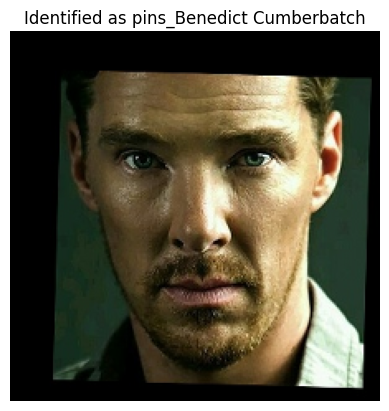

In [64]:
# predict_test('/content/drive/My Drive/GL/CV-2 Dataset/Benedict Cumberbatch9.jpg')
predict_test('Benedict Cumberbatch9.jpg')